# Calculando los movimientos propios para poder aplicar la máscara de Sagittarius a la simulación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord, CartesianRepresentation
from astropy.wcs import WCS
import gala.coordinates as gc
import healpy as hp
from pylab import cm
import matplotlib as mpl
from matplotlib.patches import Circle, PathPatch, Ellipse
from healpy.newvisufunc import projview, newprojplot
from mpl_toolkits.mplot3d import Axes3D
from astropy.coordinates import cartesian_to_spherical
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.legend_handler import HandlerTuple
import datosCM
import pymaster as nmt

from matplotlib.patches import Rectangle

In [2]:
from astropy.coordinates import SkyCoord

def cat_to_hpx(lon, lat, nside, radec=False):   #radec=False: si vamos de cartesianas a esfericas galacticas
    """
    Convierte un catálogo a un mapa HEALPix de densidad de número, es decir,
    el número de estrellas por grado cuadrado de cielo.

    Parámetros
    ----------
    lon, lat : (arreglo, arreglo)
        Coordenadas de las fuentes en grados.
        Si radec=True, asume que la entrada está en el sistema ICRS,
        De lo contrario, asume que la entrada está en latitud y longitud galáctica.

    nside : int
        Número HEALPix nside del mapa de destino, define el número de píxeles.

    radec : bool
        Cambio entre Ra/Dec y l/b (galáctico) como sistema de coordenadas de entrada.

    Return
    ------
    hpx_map : arreglo
        Mapa HEALPix de los recuentos de número del catálogo en coordenadas galácticas
    """
    npix = hp.nside2npix(nside)

    if radec:
        eq = SkyCoord(lon, lat, unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # OJO ACA  

    theta = np.radians(90. - b)                 # latitud en radianes
    phi = np.radians(l)               # longitud en radianes        
    indices = hp.ang2pix(nside, theta, phi, lonlat=False)  


    indx, counts = np.unique(indices, return_counts=True)

    # llenar el mapa de cielo completo
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[indx] = counts

    return hpx_map


In [3]:
fwhm2sigma = lambda fwhm: fwhm / np.sqrt(8*np.log(2))


## Leyendo los datos de la simulación

In [4]:
#lectura de datos

#simu = pd.read_csv('rand_mwlmc5b0_110.txt', sep=' ',names=['x','y','z','vx', 'vy', 'vz'])

simu = pd.read_csv('/home/marz/Dropbox/PlanAB/gkrr/Wake/notebooks wake simu/rand_mwlmc5b0_110.txt', sep=' ',
         names=['x','y','z','vx', 'vy', 'vz'])

#mc = pd.read_csv('/content/drive/MyDrive/rand_mwb1_110.txt', sep=' ',
                  #names=['x','y','z','vx', 'vy', 'vz'])
#pd.DataFrame(mc)

# con x,y,z en kpc y vx, vy, vz en km/s

simu

,x,y,z,vx,vy,vz
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468
...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112


In [5]:
from astropy.coordinates import cartesian_to_spherical

x = simu['x'].values #* u.Mpc
y = simu['y'].values #* u.Mpc
z = simu['z'].values #* u.Mpc

#
spherical_coords = cartesian_to_spherical(x, y, z)

#
r = spherical_coords[0]#.to(u.Mpc, equivalencies=u.dimensionless_angles()).value
theta = spherical_coords[1].to(u.rad).value
phi = spherical_coords[2].to(u.rad).value
phi2 = spherical_coords[2].to(u.degree).value

# Añadir los resultados de nuevo al DataFrame
simu['R'] = r                #kpc
simu['theta'] = theta        #rad
simu['phi'] = phi            #rad
simu['phi2'] = phi2         # en grados
simu['cotheta'] = np.pi/2 - theta          #rad

simu

,x,y,z,vx,vy,vz,R,theta,phi,phi2,cotheta
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394,144.725804,0.371843,1.638144,93.858739,1.198953
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051,148.867090,-1.153711,2.061239,118.100309,2.724507
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043,54.944456,-0.372584,4.823451,276.363373,1.943380
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506,58.187588,-0.276577,4.038123,231.367392,1.847374
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468,87.843498,-0.921048,2.699603,154.675846,2.491844
...,...,...,...,...,...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295,52.956569,-0.014487,3.121629,178.856162,1.585284
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743,50.392385,-0.773559,1.482719,84.953513,2.344356
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645,65.396728,1.372764,0.430417,24.661104,0.198033
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112,175.489218,-0.117324,2.043006,117.055644,1.688120


### Velocidades 

In [6]:
simu['vr'] = np.sin(simu['cotheta']) * np.cos(simu['phi'])* simu['vx'] + np.sin(simu['cotheta']) * np.sin(simu['phi']) * simu['vy'] + np.cos(simu['cotheta']) * simu['vz']
simu['vtheta'] = np.cos(simu['cotheta'])* np.cos(simu['phi']) * simu['vx'] + np.sin(simu['phi']) * np.cos(simu['cotheta']) * simu['vy'] - np.sin(simu['cotheta']) * simu['vz']
simu['vphi'] =  ( np.sin(simu['phi'])) * simu['vx'] -  np.cos(simu['phi']) * simu['vy']

In [7]:
vr= simu['vr'].values                         #km/s
vtheta = simu['vtheta'].values                 #km/s
vphi = simu['vphi'].values                     #km/s

vx= simu['vx'].values                     #km/s
vy= simu['vy'].values                     #km/s
vz= simu['vz'].values                     #km/s

## Para los movimientos propios

In [8]:
coord_gc = SkyCoord(
    x = x * u.kpc,
    y = y * u.kpc,
    z = z * u.kpc,
    v_x = vx * u.km/u.s,
    v_y = vy * u.km/u.s,
    v_z = vz * u.km/u.s,
    frame = 'galactocentric'
)

In [9]:
coord_icrs = coord_gc.transform_to('icrs')

simu['ra'] = coord_icrs.ra.deg
simu['dec'] = coord_icrs.dec.deg
simu['pmra'] = coord_icrs.pm_ra_cosdec.to(u.mas/u.yr).value
simu['pmdec'] = coord_icrs.pm_dec.to(u.mas/u.yr).value
simu['distance'] = coord_icrs.distance.to(u.kpc)
simu['v_radial'] = coord_icrs.radial_velocity.to(u.km/u.s).value


In [10]:
coord_gc2 = coord_icrs.transform_to('galactocentric')
vrad_corregida = coord_gc2.radial_velocity.to(u.km/u.s).value     #corregida por el movimiento del sol
simu['vrad_corregida'] = vrad_corregida

In [11]:
simu

,x,y,z,vx,vy,vz,R,theta,phi,phi2,...,vr,vtheta,vphi,ra,dec,pmra,pmdec,distance,v_radial,vrad_corregida
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394,144.725804,0.371843,1.638144,93.858739,...,17.383351,-96.700000,-163.920219,286.802297,59.918933,-0.174810,0.327564,144.436632,-223.220818,17.383351
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051,148.867090,-1.153711,2.061239,118.100309,...,-228.473928,-53.704088,-73.073356,8.103395,-4.942544,0.279041,-0.194261,147.552128,-312.559686,-228.473928
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043,54.944456,-0.372584,4.823451,276.363373,...,-152.625037,-179.705594,30.804147,120.538729,-72.636358,0.714678,0.728653,56.372208,66.710877,-152.625037
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506,58.187588,-0.276577,4.038123,231.367392,...,13.993760,-255.470709,-63.951784,97.762680,-30.166152,1.395962,-0.160351,53.709786,223.461639,13.993760
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468,87.843498,-0.921048,2.699603,154.675846,...,-75.773520,170.486610,0.332925,27.405095,2.915062,0.191853,-0.836524,83.696146,-117.624650,-75.773520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295,52.956569,-0.014487,3.121629,178.856162,...,29.629009,28.738077,112.559469,84.465341,29.474195,0.191623,-0.621472,44.837874,37.365674,29.629009
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743,50.392385,-0.773559,1.482719,84.953513,...,119.857508,-44.714493,147.338962,338.322676,5.863770,-0.234923,-0.823262,51.559076,-26.669877,119.857508
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645,65.396728,1.372764,0.430417,24.661104,...,-74.772571,-172.208982,-95.462462,210.813080,20.665899,-0.924154,-0.154685,67.305031,-128.373692,-74.772571
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112,175.489218,-0.117324,2.043006,117.055644,...,110.032282,15.767699,70.853064,358.354290,55.003400,0.070544,-0.045461,171.975499,-102.433850,110.032282


In [12]:
print(theta.min(), theta.max())
print(phi.min(), phi.max())

-1.568702387280011 1.5674532971751243
5.850232583308473e-07 6.283184329953387


# Ahora que tengo los pm aplico la máscara de Sgr a los datos de la simulación

In [13]:
from astropy.coordinates.matrix_utilities import matrix_transpose, rotation_matrix
from astropy.coordinates import frame_transform_graph

In [14]:
class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        https://ui.adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        https://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `~astropy.coordinates.BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `~astropy.coordinates.Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `~astropy.coordinates.Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `~astropy.units.Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : `~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : `~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : `~astropy.units.Quantity`, optional, keyword-only
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }

In [15]:
SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree

# Generate the rotation matrix using the x-convention (see Goldstein)
SGR_MATRIX = (
    np.diag([1.,1.,-1.])
    @ rotation_matrix(SGR_PSI, "z")
    @ rotation_matrix(SGR_THETA, "x")
    @ rotation_matrix(SGR_PHI, "z")
)

In [16]:
@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

In [17]:
@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)

### para l y b galacticas

In [18]:
nside=128

l_sim = coord.Angle(simu['phi'].values*180/np.pi*u.degree)
l_sim = l_sim.wrap_at(180*u.degree)
b_sim = coord.Angle(simu['theta'].values*180/np.pi*u.degree)

simu['l_sim'] = l_sim
simu['b_sim'] = b_sim


c2 = SkyCoord(l=l_sim, b=b_sim, frame='galactic',unit=u.deg)
sgr = c2.transform_to(Sagittarius)


In [19]:
#calculo la latitud en ese nuevo sistema para cada uno de los datos y lo agrego a mi dataframe
simu['Beta']=sgr.Beta.deg
simu


,x,y,z,vx,vy,vz,R,theta,phi,phi2,...,ra,dec,pmra,pmdec,distance,v_radial,vrad_corregida,l_sim,b_sim,Beta
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394,144.725804,0.371843,1.638144,93.858739,...,286.802297,59.918933,-0.174810,0.327564,144.436632,-223.220818,17.383351,93.858739,21.305058,-82.154257
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051,148.867090,-1.153711,2.061239,118.100309,...,8.103395,-4.942544,0.279041,-0.194261,147.552128,-312.559686,-228.473928,118.100309,-66.102768,-8.401635
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043,54.944456,-0.372584,4.823451,276.363373,...,120.538729,-72.636358,0.714678,0.728653,56.372208,66.710877,-152.625037,-83.636627,-21.347494,81.728455
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506,58.187588,-0.276577,4.038123,231.367392,...,97.762680,-30.166152,1.395962,-0.160351,53.709786,223.461639,13.993760,-128.632608,-15.846722,48.993057
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468,87.843498,-0.921048,2.699603,154.675846,...,27.405095,2.915062,0.191853,-0.836524,83.696146,-117.624650,-75.773520,154.675846,-52.772144,-5.772322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295,52.956569,-0.014487,3.121629,178.856162,...,84.465341,29.474195,0.191623,-0.621472,44.837874,37.365674,29.629009,178.856162,-0.830069,-4.564755
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743,50.392385,-0.773559,1.482719,84.953513,...,338.322676,5.863770,-0.234923,-0.823262,51.559076,-26.669877,119.857508,84.953513,-44.321677,-31.665750
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645,65.396728,1.372764,0.430417,24.661104,...,210.813080,20.665899,-0.924154,-0.154685,67.305031,-128.373692,-74.772571,24.661104,78.653565,-17.248042
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112,175.489218,-0.117324,2.043006,117.055644,...,358.354290,55.003400,0.070544,-0.045461,171.975499,-102.433850,110.032282,117.055644,-6.722158,-59.293523


In [20]:
for col in simu.columns:
    if hasattr(simu[col].iloc[0], 'unit'):
        try:
            simu[col] = simu[col].apply(lambda x: x.to(u.dimensionless_unscaled).value if hasattr(x, 'unit') else x)
        except:
            simu[col] = simu[col].apply(lambda x: x.value if hasattr(x, 'unit') else x)


In [21]:
simu_original = simu.copy()


In [22]:
mask_sgr_total = (
    ((simu['b_sim'] > 0) & (abs(simu['Beta']) < 15) & (simu['pmra'] > -1.3)) |
    ((simu['b_sim'] > 0) & (abs(simu['Beta']) < 15) & (simu['pmdec'] > -0.4) & (simu['pmdec'] < 0.3)) |
    ((simu['b_sim'] > 0) & (abs(simu['Beta']) < 15) & (simu['pmdec'] > (1.7 * simu['pmra'] + 0.4))) |
    ((simu['b_sim'] > 0) & (simu['l_sim'] < 210) & (simu['l_sim'] > 180))
)


simu_original_sgr = simu[~mask_sgr_total].copy()


In [23]:
simu_original_sgr

,x,y,z,vx,vy,vz,R,theta,phi,phi2,...,ra,dec,pmra,pmdec,distance,v_radial,vrad_corregida,l_sim,b_sim,Beta
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394,144.725804,0.371843,1.638144,93.858739,...,286.802297,59.918933,-0.174810,0.327564,144.436632,-223.220818,17.383351,93.858739,21.305058,-82.154257
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051,148.867090,-1.153711,2.061239,118.100309,...,8.103395,-4.942544,0.279041,-0.194261,147.552128,-312.559686,-228.473928,118.100309,-66.102768,-8.401635
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043,54.944456,-0.372584,4.823451,276.363373,...,120.538729,-72.636358,0.714678,0.728653,56.372208,66.710877,-152.625037,-83.636627,-21.347494,81.728455
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506,58.187588,-0.276577,4.038123,231.367392,...,97.762680,-30.166152,1.395962,-0.160351,53.709786,223.461639,13.993760,-128.632608,-15.846722,48.993057
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468,87.843498,-0.921048,2.699603,154.675846,...,27.405095,2.915062,0.191853,-0.836524,83.696146,-117.624650,-75.773520,154.675846,-52.772144,-5.772322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295,52.956569,-0.014487,3.121629,178.856162,...,84.465341,29.474195,0.191623,-0.621472,44.837874,37.365674,29.629009,178.856162,-0.830069,-4.564755
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743,50.392385,-0.773559,1.482719,84.953513,...,338.322676,5.863770,-0.234923,-0.823262,51.559076,-26.669877,119.857508,84.953513,-44.321677,-31.665750
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645,65.396728,1.372764,0.430417,24.661104,...,210.813080,20.665899,-0.924154,-0.154685,67.305031,-128.373692,-74.772571,24.661104,78.653565,-17.248042
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112,175.489218,-0.117324,2.043006,117.055644,...,358.354290,55.003400,0.070544,-0.045461,171.975499,-102.433850,110.032282,117.055644,-6.722158,-59.293523


In [24]:

# pmra* y pmdec* son los movimientos propios corregidos por refle motion del sol

In [25]:
eliminadas = len(simu) - len(simu_original_sgr) 
print(f"Estrellas eliminadas: {eliminadas}")


Estrellas eliminadas: 144060


## Para la sobredensidad

In [26]:
sgr.Beta.deg = simu_original_sgr['Beta'].values
l_sim = simu_original_sgr['l_sim'].values
b_sim = simu_original_sgr['b_sim'].values


/tmp/ipykernel_15454/1908332511.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


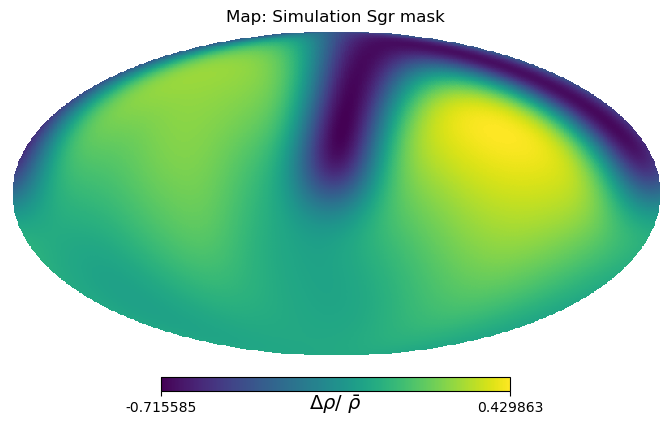

In [27]:
mapa_simulacion_sgr = cat_to_hpx(l_sim, b_sim, nside=nside, radec=False)
mapa_simulacion_mean = mapa_simulacion_sgr.mean()
mapa_simulacion_sgr = (mapa_simulacion_sgr - mapa_simulacion_mean) / mapa_simulacion_mean

# Suavizar el mapa SOLO para visualización
mapa_simulacion_sgr_smooth= hp.sphtfunc.smoothing(mapa_simulacion_sgr, sigma=np.radians(fwhm2sigma(30)))

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot()

mmin, mmax = np.min(mapa_simulacion_sgr[np.isfinite(mapa_simulacion_sgr)]), np.max(mapa_simulacion_sgr[np.isfinite(mapa_simulacion_sgr)])

hp.mollview(mapa_simulacion_sgr_smooth, title='Map: Simulation Sgr mask', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
#plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()


/tmp/ipykernel_15454/3079368770.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


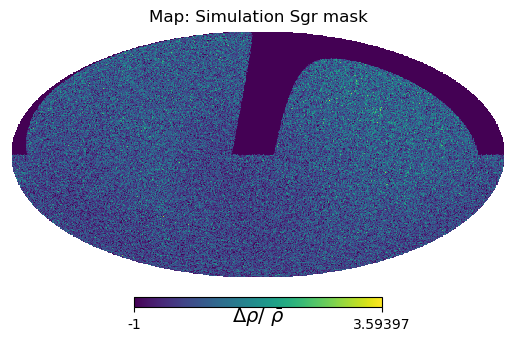

In [28]:
hp.mollview(mapa_simulacion_sgr, title='Map: Simulation Sgr mask', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
#plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()

In [29]:
n_sgr = mask_sgr_total.sum()
n_total = len(simu)
print(f"Estrellas tipo Sgr: {n_sgr} / {n_total}")
print(f"Estrellas disponibles: {n_total - n_sgr} / {n_total}")


Estrellas tipo Sgr: 144060 / 1000000
Estrellas disponibles: 855940 / 1000000


## AJustando parámetros

In [30]:
lmax=3*nside-1
#lmax=47
espesor=5 #kpc
radio=70 #kpc

radio_min=radio-espesor/2
radio_max=radio+espesor/2

## Calculamos los Cls y alm con ```anafast()```

In [31]:
cl_simu_sgr=hp.anafast(mapa_simulacion_sgr, alm=True,lmax=lmax, pol=False)

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15454/3893563439.py:8: SyntaxWarning: invalid escape sequence '\e'
  label="$C_{\ell}$ Simu sgr", marker="o", linestyle="--", color='blue', alpha=0.5)
/tmp/ipykernel_15454/3893563439.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_15454/3893563439.py:11: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_ylabel('$C_{\ell}$')

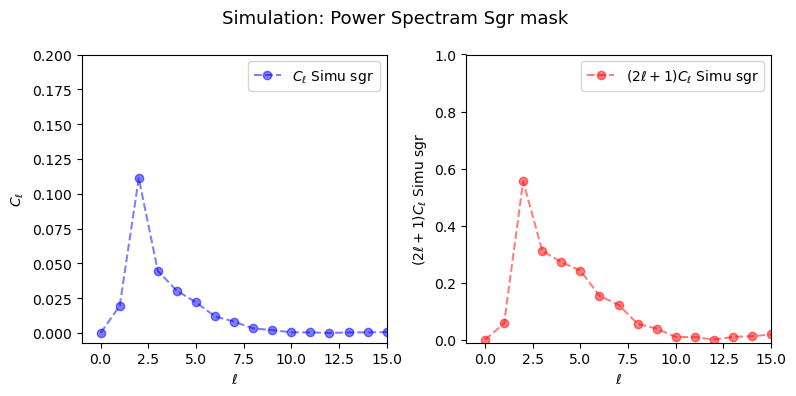

In [32]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.suptitle('Simulation: Power Spectram Sgr mask', fontsize=13)

ells = np.arange(lmax + 1)


ax[0].plot(ells, cl_simu_sgr[0][:lmax + 1], 
         label="$C_{\ell}$ Simu sgr", marker="o", linestyle="--", color='blue', alpha=0.5)
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(-1,15)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(-0.007, 0.20)
ax[0].legend()

ax[1].plot(ells, (2*ells +1)*cl_simu_sgr[0][:lmax + 1], 
         label="$(2 \ell +1) C_{\ell}$ Simu sgr", marker="o", linestyle="--", color='red', alpha=0.5)
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(-1,15)
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$ Simu sgr')
ax[1].set_ylim(-0.01, 1)
ax[1].legend()

#plt.savefig('cl_sobre_simu_'+str(radio)+'.pdf') 
plt.tight_layout()
plt.show()



## Con la condición de 70 kpc $\pm$ 5 kpc

In [33]:
simu_original_sgr

,x,y,z,vx,vy,vz,R,theta,phi,phi2,...,ra,dec,pmra,pmdec,distance,v_radial,vrad_corregida,l_sim,b_sim,Beta
0,-9.073973,134.529449,52.583729,-162.274078,-29.927361,96.407394,144.725804,0.371843,1.638144,93.858739,...,286.802297,59.918933,-0.174810,0.327564,144.436632,-223.220818,17.383351,93.858739,21.305058,-82.154257
1,-28.404976,53.197102,-136.105240,-43.992241,-72.750572,230.643051,148.867090,-1.153711,2.061239,118.100309,...,8.103395,-4.942544,0.279041,-0.194261,147.552128,-312.559686,-228.473928,118.100309,-66.102768,-8.401635
2,5.671879,-50.859417,-20.001068,-39.119331,72.849449,222.935043,54.944456,-0.372584,4.823451,276.363373,...,120.538729,-72.636358,0.714678,0.728653,56.372208,66.710877,-152.625037,-83.636627,-21.347494,81.728455
3,-34.947304,-43.726669,-15.888982,-2.000596,-104.936783,241.940506,58.187588,-0.276577,4.038123,231.367392,...,97.762680,-30.166152,1.395962,-0.160351,53.709786,223.461639,13.993760,-128.632608,-15.846722,48.993057
4,-48.037086,22.731808,-69.944145,164.281570,-77.371971,-42.808468,87.843498,-0.921048,2.699603,154.675846,...,27.405095,2.915062,0.191853,-0.836524,83.696146,-117.624650,-75.773520,154.675846,-52.772144,-5.772322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,-52.940460,1.057030,-0.767179,-26.956795,113.120132,-29.164295,52.956569,-0.014487,3.121629,178.856162,...,84.465341,29.474195,0.191623,-0.621472,44.837874,37.365674,29.629009,178.856162,-0.830069,-4.564755
999996,3.171290,35.912395,-35.208454,157.058807,103.576843,-51.752743,50.392385,-0.773559,1.482719,84.953513,...,338.322676,5.863770,-0.234923,-0.823262,51.559076,-26.669877,119.857508,84.953513,-44.321677,-31.665750
999997,11.692700,5.368427,64.118584,-206.644135,10.167513,-39.430645,65.396728,1.372764,0.430417,24.661104,...,210.813080,20.665899,-0.924154,-0.154685,67.305031,-128.373692,-74.772571,24.661104,78.653565,-17.248042
999998,-79.273514,155.210205,-20.541859,14.234056,127.901489,-28.539112,175.489218,-0.117324,2.043006,117.055644,...,358.354290,55.003400,0.070544,-0.045461,171.975499,-102.433850,110.032282,117.055644,-6.722158,-59.293523


In [34]:

simu_original_sgr = simu[~mask_sgr_total].copy()

#
simu_condicion_sgr70 = simu_original_sgr[(simu_original_sgr['R'] < radio_max) & (simu_original_sgr['R'] > radio_min)].copy()

# 3. Reseteás el índice
simu_condicion_sgr70.reset_index(drop=True, inplace=True)


In [35]:
print(len(simu_condicion_sgr70))
simu_condicion_sgr70

34507


,x,y,z,vx,vy,vz,R,theta,phi,phi2,...,ra,dec,pmra,pmdec,distance,v_radial,vrad_corregida,l_sim,b_sim,Beta
0,-53.061398,41.455952,22.344593,86.953850,13.938704,-154.251755,70.946379,0.320404,2.478369,142.000104,...,77.387840,74.979359,-0.019593,-0.466573,65.088398,-254.251769,-105.470404,142.000104,18.357822,-43.467512
1,0.624012,50.123386,-51.375473,16.287613,178.196594,-109.710022,71.778705,-0.797695,1.558347,89.286732,...,343.899641,7.724207,0.195560,-0.325854,72.321663,37.190659,203.101807,89.286732,-45.704544,-30.698117
2,-54.970650,44.175541,-5.324710,85.223404,66.308495,11.412510,70.722014,-0.075362,2.464648,141.213928,...,37.474694,55.370518,0.231464,-0.131643,64.613090,-175.320088,-25.682817,141.213928,-4.317925,-39.649803
3,14.865033,54.219166,-41.813835,-170.884308,118.176590,194.248260,70.064855,-0.639492,1.303206,74.668202,...,329.756059,8.179834,0.140955,0.342446,72.237505,-262.111403,-60.729869,74.668202,-36.640169,-36.767464
4,22.350819,61.281734,-26.018353,14.321036,2.820848,4.897541,70.227948,-0.379530,1.221066,69.961957,...,316.340301,15.170317,-0.010104,-0.389843,73.226221,-201.561237,5.204871,69.961957,-21.745489,-47.760948
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34502,41.628483,-11.116068,-54.504440,196.042603,103.060272,79.880615,69.478281,-0.901860,6.022243,345.049131,...,324.441718,-50.079004,-0.490402,-0.406925,74.643665,90.625319,38.306689,-14.950869,-51.672767,22.084721
34503,3.573742,-28.529005,-61.892181,-31.530685,-15.743123,-209.615891,68.244545,-1.135909,4.837007,277.140077,...,20.542180,-53.035052,0.498153,-0.190497,69.165824,294.883185,195.034459,-82.859923,-65.082808,38.324807
34504,15.123265,-64.108955,-22.831352,51.960236,185.951706,-43.565121,69.713284,-0.333660,4.944053,283.273377,...,136.111070,-75.269550,-0.031293,-0.086226,71.920235,82.109032,-145.463103,-76.726623,-19.117325,79.254545
34505,16.201511,-35.835152,60.443825,-21.060043,-17.799568,132.427338,72.111740,0.993968,5.136998,294.328309,...,193.485754,-8.416747,-0.494235,-0.262707,74.341993,217.165365,115.113857,-65.671691,56.950186,17.544199


In [36]:
l_sim = coord.Angle(simu_condicion_sgr70['phi'].values*180/np.pi*u.degree)
l_sim = l_sim.wrap_at(180*u.degree)
b_sim = coord.Angle(simu_condicion_sgr70['theta'].values*180/np.pi*u.degree)

simulacion= SkyCoord(l=l_sim, b=b_sim, frame='galactic')
ipix_simulacion = hp.ang2pix(nside, np.pi/2- simulacion.galactic.b.radian, simulacion.galactic.l.radian)

/tmp/ipykernel_15454/2639734125.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


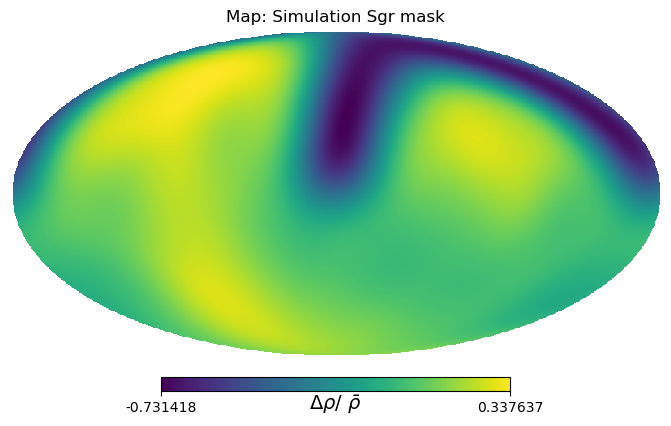

In [37]:
#sobredensidad (no suavizado)
l = simulacion.galactic.l.degree
b = simulacion.galactic.b.degree
mapa_simulacion_sgr70 = cat_to_hpx(l, b, nside=nside, radec=False)
mapa_simulacion_mean = mapa_simulacion_sgr70.mean()
mapa_simulacion_sgr70 = (mapa_simulacion_sgr70 - mapa_simulacion_mean) / mapa_simulacion_mean


# Suavizar el mapa SOLO para visualización
mapa_simulacion_sgr70_smooth= hp.sphtfunc.smoothing(mapa_simulacion_sgr70, sigma=np.radians(fwhm2sigma(30)))

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot()

mmin, mmax = np.min(mapa_simulacion_sgr70[np.isfinite(mapa_simulacion_sgr70)]), np.max(mapa_simulacion_sgr70[np.isfinite(mapa_simulacion_sgr70)])

hp.mollview(mapa_simulacion_sgr70_smooth, title='Map: Simulation Sgr mask', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
#plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()

/tmp/ipykernel_15454/1404626770.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


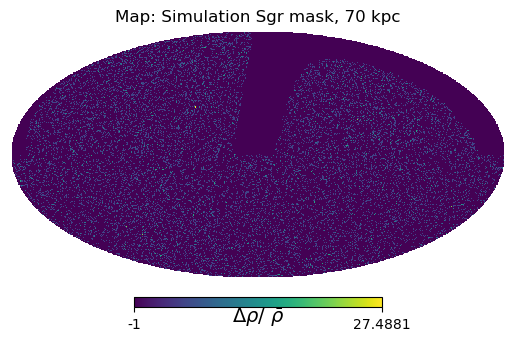

In [38]:
hp.mollview(mapa_simulacion_sgr70, title='Map: Simulation Sgr mask, '+str(radio)+' kpc',
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
#plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()

In [39]:
print(f"Estrellas disponibles (sin Sgr, en 70 +- 2.5 kpc): {len(simu_condicion_sgr70)}")


Estrellas disponibles (sin Sgr, en 70 +- 2.5 kpc): 34507


## Calculando los $C_{\ell}$ y $a_{\ell m}$

In [40]:
cl_simu_sg70r=hp.anafast(mapa_simulacion_sgr70, alm=True,lmax=lmax, pol=False)

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15454/2428554355.py:8: SyntaxWarning: invalid escape sequence '\e'
  label="$C_{\ell}$ Simu sgr, "+str(radio)+" kpc", marker="o", linestyle="--", color='blue', alpha=0.5)
/tmp/ipykernel_15454/2428554355.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_15454/2428554355.py:11: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_

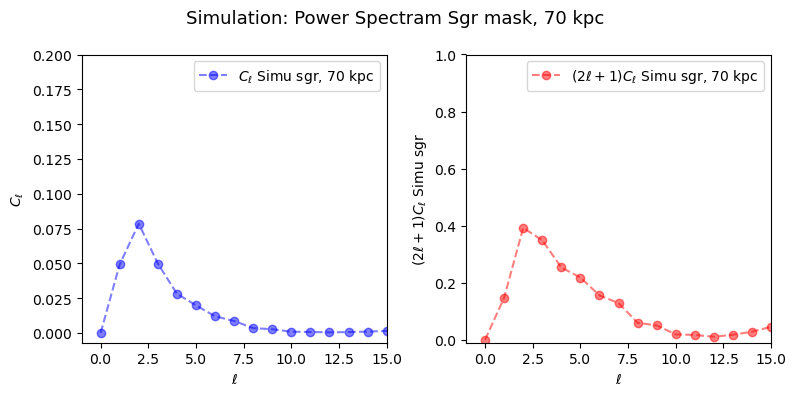

In [41]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.suptitle('Simulation: Power Spectram Sgr mask, '+str(radio)+' kpc', fontsize=13)

ells = np.arange(lmax + 1)


ax[0].plot(ells, cl_simu_sg70r[0][:lmax + 1], 
         label="$C_{\ell}$ Simu sgr, "+str(radio)+" kpc", marker="o", linestyle="--", color='blue', alpha=0.5)
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(-1,15)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(-0.007, 0.20)
ax[0].legend()

ax[1].plot(ells, (2*ells +1)*cl_simu_sg70r[0][:lmax + 1], 
         label="$(2 \ell +1) C_{\ell}$ Simu sgr, "+str(radio)+" kpc", marker="o", linestyle="--", color='red', alpha=0.5)
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(-1,15)
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$ Simu sgr')
ax[1].set_ylim(-0.01, 1)
ax[1].legend()

#plt.savefig('cl_sobre_simu_'+str(radio)+'.pdf') 
plt.tight_layout()
plt.show()



## Haciendo un subsampleo para la misma condición 

In [42]:
# Submuestreamos 300 estrellas
simu_sample_sgr70 = simu_condicion_sgr70.sample(n=300, random_state=42)
simu_sample_sgr70.reset_index(drop=True, inplace=True)

In [43]:
l_sim = coord.Angle(simu_sample_sgr70['phi'].values*180/np.pi*u.degree)
l_sim = l_sim.wrap_at(180*u.degree)
b_sim = coord.Angle(simu_sample_sgr70['theta'].values*180/np.pi*u.degree)

simulacion= SkyCoord(l=l_sim, b=b_sim, frame='galactic')
ipix_simulacion = hp.ang2pix(nside, np.pi/2- simulacion.galactic.b.radian, simulacion.galactic.l.radian)

/tmp/ipykernel_15454/1805610274.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


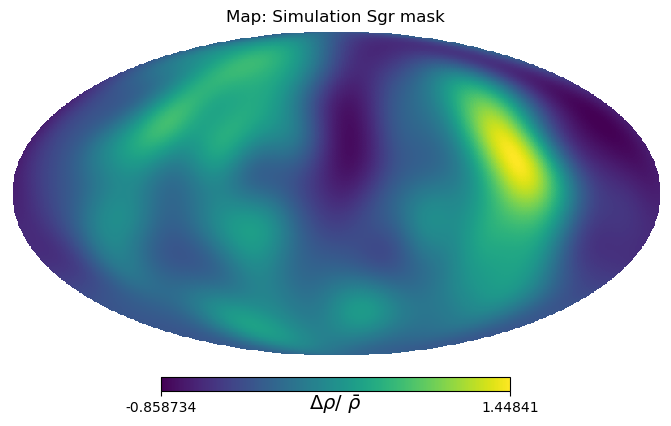

In [44]:
#sobredensidad (no suavizado)
l = simulacion.galactic.l.degree
b = simulacion.galactic.b.degree
mapa_sample_simu_sgr70 = cat_to_hpx(l, b, nside=nside, radec=False)
mapa_simulacion_mean = mapa_sample_simu_sgr70.mean()
mapa_sample_simu_sgr70 = (mapa_sample_simu_sgr70 - mapa_simulacion_mean) / mapa_simulacion_mean


# Suavizar el mapa SOLO para visualización
mapa_sample_simu_sgr70_smooth= hp.sphtfunc.smoothing(mapa_sample_simu_sgr70, sigma=np.radians(fwhm2sigma(30)))

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot()

mmin, mmax = np.min(mapa_sample_simu_sgr70[np.isfinite(mapa_sample_simu_sgr70)]), np.max(mapa_sample_simu_sgr70[np.isfinite(mapa_sample_simu_sgr70)])

hp.mollview(mapa_sample_simu_sgr70_smooth, title='Map: Simulation Sgr mask', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
#plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()

/tmp/ipykernel_15454/3692630758.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


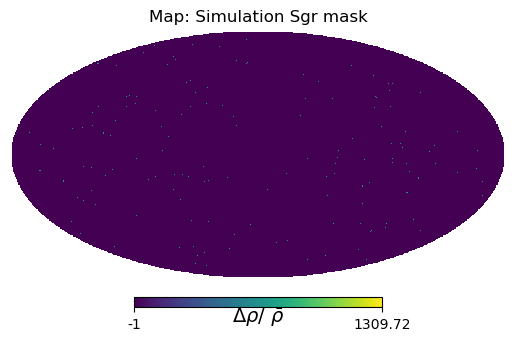

In [45]:
hp.mollview(mapa_sample_simu_sgr70, title='Map: Simulation Sgr mask', 
            unit=r"$\Delta \rho /\ \bar{\rho}$",  cbar=True, flip='astro', hold=True) 

plt.tight_layout()
#plt.savefig('mapa_simulacion_smooth_masked_'+str(radio)+'.pdf')
plt.show()

In [46]:
# Definí la condición del anillo sobre la submuestra
mask_anillo_sample = simu_sample_sgr70['R'].between(radio_min, radio_max)

# Definí la máscara tipo Sgr sobre la submuestra
mask_sgr_sample = (
    ((simu_sample_sgr70['b_sim'] > 0) & (abs(simu_sample_sgr70['Beta']) < 15) & (simu_sample_sgr70['pmra'] > -1.3)) |
    ((simu_sample_sgr70['b_sim'] > 0) & (abs(simu_sample_sgr70['Beta']) < 15) &
     (simu_sample_sgr70['pmdec'] > -0.4) & (simu_sample_sgr70['pmdec'] < 0.3)) |
    ((simu_sample_sgr70['b_sim'] > 0) & (abs(simu_sample_sgr70['Beta']) < 15) &
     (simu_sample_sgr70['pmdec'] > (1.7 * simu_sample_sgr70['pmra'] + 0.4))) |
    ((simu_sample_sgr70['b_sim'] > 0) & (simu_sample_sgr70['l_sim'] < 210) & (simu_sample_sgr70['l_sim'] > 180))
)

# Ahora sí, hacés los conteos
n_total_sample = len(simu_sample_sgr70)
n_dentro_anillo = mask_anillo_sample.sum()
n_fuera_anillo = n_total_sample - n_dentro_anillo
n_sgr_sample = mask_sgr_sample.sum()

# Mostrás resultados
print("🧾 Verificación de submuestra simu_sample_sgr70")
print(f"Total de estrellas en la submuestra: {n_total_sample}")
print(f"  ✔ Dentro del anillo 70±2.5 kpc: {n_dentro_anillo} / {n_total_sample}")
print(f"  ❌ Fuera del anillo: {n_fuera_anillo}")
print(f"  ⚠ Posibles tipo Sgr remanentes: {n_sgr_sample}")


🧾 Verificación de submuestra simu_sample_sgr70
Total de estrellas en la submuestra: 300
  ✔ Dentro del anillo 70±2.5 kpc: 300 / 300
  ❌ Fuera del anillo: 0
  ⚠ Posibles tipo Sgr remanentes: 0


## Calculando los $C_{\ell}$ y $a_{\ell m}$

In [47]:
cl_simu_sg70_sample=hp.anafast(mapa_sample_simu_sgr70, alm=True,lmax=lmax, pol=False)

<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:9: SyntaxWarning: invalid escape sequence '\e'
<>:11: SyntaxWarning: invalid escape sequence '\e'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_15454/1378896950.py:8: SyntaxWarning: invalid escape sequence '\e'
  label="$C_{\ell}$ Simu sgr, "+str(radio)+" kpc", marker="o", linestyle="--", color='blue', alpha=0.5)
/tmp/ipykernel_15454/1378896950.py:9: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_xlabel('$\ell$')
/tmp/ipykernel_15454/1378896950.py:11: SyntaxWarning: invalid escape sequence '\e'
  ax[0].set_

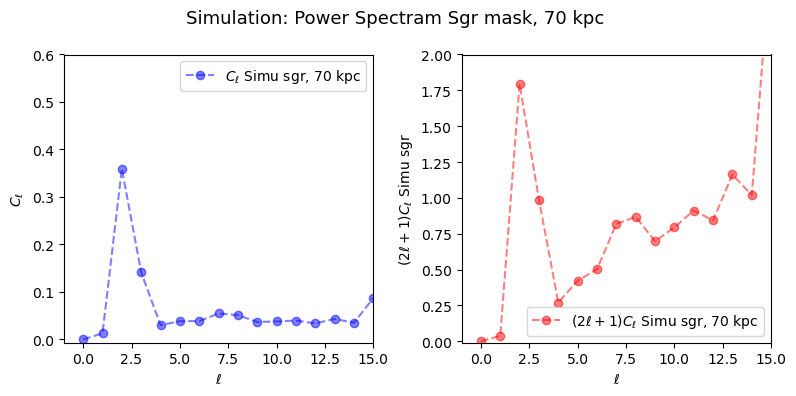

In [48]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
fig.suptitle('Simulation: Power Spectram Sgr mask, '+str(radio)+' kpc', fontsize=13)

ells = np.arange(lmax + 1)


ax[0].plot(ells, cl_simu_sg70_sample[0][:lmax + 1], 
         label="$C_{\ell}$ Simu sgr, "+str(radio)+" kpc", marker="o", linestyle="--", color='blue', alpha=0.5)
ax[0].set_xlabel('$\ell$')
ax[0].set_xlim(-1,15)
ax[0].set_ylabel('$C_{\ell}$')
ax[0].set_ylim(-0.007, 0.6)
ax[0].legend()

ax[1].plot(ells, (2*ells +1)*cl_simu_sg70_sample[0][:lmax + 1], 
         label="$(2 \ell +1) C_{\ell}$ Simu sgr, "+str(radio)+" kpc", marker="o", linestyle="--", color='red', alpha=0.5)
ax[1].set_xlabel('$\ell$')
ax[1].set_xlim(-1,15)
ax[1].set_ylabel('$(2 \ell +1) C_{\ell}$ Simu sgr')
ax[1].set_ylim(-0.01, 2)
ax[1].legend()

#plt.savefig('cl_sobre_simu_'+str(radio)+'.pdf') 
plt.tight_layout()
plt.show()

